# 2019년 12월 13일

모델 학습하면 모델 저장하기 * 

tensorflow_hub 
1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for our dataset.

    You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to original classification task, and subsequently specific to the set of classes on which the model was trained.
    

2. Fine-Tuning: Unfreezing a few of the top layers of a frozen model base and jointly training both the newly-added classifier layers and the last layers of the base model. This allows us to "fine tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
2. Build an input pipeline, in this case using Keras ImageDataGenerator
3. Compose our model
4. Load in our pretrained base model (and pretrained weights)
5. Stack our classification layers on top
6. Train our model
7. Evaluate model

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
# keras = tf.keras -> keras를 못 불러온다. 

# fine tuning : keras.applications 

In [3]:
tf.__version__

'2.0.0'

- tfds : 연습용 데이터들 

In [4]:
import tensorflow_datasets as tfds

---

In [42]:
'Split' in dir(tfds)

True

In [43]:
# See available datasets
dir(tfds.list_builders())

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

In [44]:
# Construct a tf.data.Dataset
dataset = tfds.load(name="mnist", split=tfds.Split.TRAIN)

In [45]:
# Build your input pipeline
dataset = dataset.shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [46]:
for features in dataset.take(1):
    image, label = features["image"], features["label"]

KeyboardInterrupt: 

---

In [5]:
# tfds.disable_progress_bar()
# 데이터 다운 받을 때 파란색 로딩 안나오는 것 

In [6]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

In [7]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)
# with_info= True : metadata를 불러온다. 

In [8]:
dir(tfds.Split)

['ALL',
 'TEST',
 'TRAIN',
 'VALIDATION',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__']

In [9]:
# supervised/unsupervised data에 둘다 쓸 수 있다. 
from sklearn.model_selection import train_test_split

In [10]:
# scikit은 validation과 함께 3개로 못쪼갠다. 두번씩 쪼개야한다. 

In [11]:
# 숫자에서 string으로 바꾸는 것 
get_label_name = metadata.features['label'].int2str

In [12]:
import matplotlib.pyplot as plt

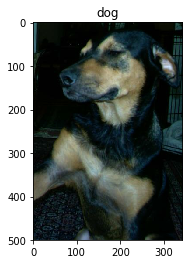

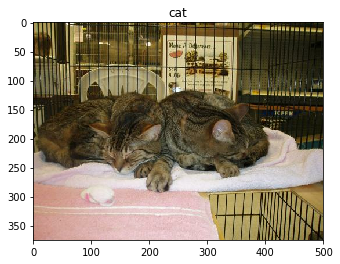

In [13]:
for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [14]:
IMG_SIZE = 160 # All images will be resized to 160x160


# 함수를 만들고, map에 넣어 준다. 
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    # image : [-1,1]
    # hyperbolic tangent 
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [15]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [16]:
# Now shuffle and batch the data.
# tfds.dataset이면 다음 기능을 쓸 수 있다. 

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [17]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
# train_batches와 같은 것들은 개인을 각가 보는 것이 아닌 전체를 포함하고 있기 때문에 
# for문으로 쪼개줘야한다. 
for image_batch, label_batch in train_batches.take(1):
    pass

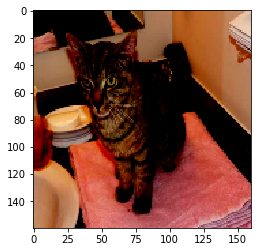

In [33]:
plt.imshow(image_batch[12])

In [184]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [185]:
# layer별로 trainable할 수 있지만, 여기서는 모델 자체를 trainable=False 해줬다. 
base_model.trainable = False

In [186]:
base_model.summary()
# trainable_false하면 trainable params가 0이 된다. 그리고 Non-ptrainable params수가 늘어난다. 

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

block_4_expand_relu (ReLU)      (None, 20, 20, 192)  0           block_4_expand_BN[0][0]          
__________________________________________________________________________________________________
block_4_depthwise (DepthwiseCon (None, 20, 20, 192)  1728        block_4_expand_relu[0][0]        
__________________________________________________________________________________________________
block_4_depthwise_BN (BatchNorm (None, 20, 20, 192)  768         block_4_depthwise[0][0]          
__________________________________________________________________________________________________
block_4_depthwise_relu (ReLU)   (None, 20, 20, 192)  0           block_4_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_4_project (Conv2D)        (None, 20, 20, 32)   6144        block_4_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_4_pr

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, 10, 10, 64)   24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, 10, 10, 64)   256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, 10, 10, 64)   0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, 10, 10, 384)  24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

__________________________________________________________________________________________________
block_13_expand_BN (BatchNormal (None, 10, 10, 576)  2304        block_13_expand[0][0]            
__________________________________________________________________________________________________
block_13_expand_relu (ReLU)     (None, 10, 10, 576)  0           block_13_expand_BN[0][0]         
__________________________________________________________________________________________________
block_13_pad (ZeroPadding2D)    (None, 11, 11, 576)  0           block_13_expand_relu[0][0]       
__________________________________________________________________________________________________
block_13_depthwise (DepthwiseCo (None, 5, 5, 576)    5184        block_13_pad[0][0]               
__________________________________________________________________________________________________
block_13_depthwise_BN (BatchNor (None, 5, 5, 576)    2304        block_13_depthwise[0][0]         
__________

In [187]:
# binary: sigmoid
# multiclass: softmax 

In [188]:
# 공간적 정보를 잃어버린다. 
flatten = tf.keras.layers.Flatten()
prediction_dense = tf.keras.layers.Dense(1, activation ='sigmoid')
# sigmoid 안쓰면 regression 개념으로 쓰기 때문에 실수값으로 나온다. 

In [189]:
model = tf.keras.Sequential([
  base_model,
  flatten,
  prediction_dense
])

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(2, activation ='relu'))

model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))

In [190]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [191]:
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_15 (Flatten)         (None, 32000)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 32001     
Total params: 2,289,985
Trainable params: 32,001
Non-trainable params: 2,257,984
_________________________________________________________________


In [192]:
model.fit(train_batches, epochs=1)

    174/Unknown - 27s 27s/step - loss: 1.0127 - accuracy: 0.46 - 30s 15s/step - loss: 1.8857 - accuracy: 0.46 - 33s 11s/step - loss: 1.5494 - accuracy: 0.54 - 36s 9s/step - loss: 1.2241 - accuracy: 0.6250 - 39s 8s/step - loss: 1.1776 - accuracy: 0.637 - 42s 7s/step - loss: 1.3205 - accuracy: 0.619 - 45s 6s/step - loss: 1.3000 - accuracy: 0.633 - 48s 6s/step - loss: 1.1633 - accuracy: 0.668 - 52s 6s/step - loss: 1.1019 - accuracy: 0.670 - 55s 5s/step - loss: 1.0079 - accuracy: 0.693 - 58s 5s/step - loss: 0.9460 - accuracy: 0.713 - 61s 5s/step - loss: 0.9696 - accuracy: 0.718 - 65s 5s/step - loss: 0.9236 - accuracy: 0.730 - 68s 5s/step - loss: 0.8678 - accuracy: 0.745 - 71s 5s/step - loss: 0.8279 - accuracy: 0.756 - 74s 5s/step - loss: 0.7786 - accuracy: 0.769 - 77s 5s/step - loss: 0.7403 - accuracy: 0.779 - 80s 4s/step - loss: 0.7203 - accuracy: 0.788 - 83s 4s/step - loss: 0.7352 - accuracy: 0.789 - 86s 4s/step - loss: 0.7364 - accuracy: 0.792 - 89s 4s/step - loss: 0.7101 - accuracy: 0.

    348/Unknown - 518s 3s/step - loss: 0.2890 - accuracy: 0.91 - 520s 3s/step - loss: 0.2879 - accuracy: 0.91 - 523s 3s/step - loss: 0.2890 - accuracy: 0.91 - 526s 3s/step - loss: 0.2897 - accuracy: 0.91 - 528s 3s/step - loss: 0.2883 - accuracy: 0.91 - 531s 3s/step - loss: 0.2874 - accuracy: 0.91 - 534s 3s/step - loss: 0.2859 - accuracy: 0.92 - 537s 3s/step - loss: 0.2877 - accuracy: 0.91 - 540s 3s/step - loss: 0.2862 - accuracy: 0.92 - 543s 3s/step - loss: 0.2852 - accuracy: 0.92 - 546s 3s/step - loss: 0.2842 - accuracy: 0.92 - 548s 3s/step - loss: 0.2837 - accuracy: 0.92 - 551s 3s/step - loss: 0.2829 - accuracy: 0.92 - 554s 3s/step - loss: 0.2840 - accuracy: 0.92 - 557s 3s/step - loss: 0.2828 - accuracy: 0.92 - 560s 3s/step - loss: 0.2831 - accuracy: 0.92 - 562s 3s/step - loss: 0.2824 - accuracy: 0.92 - 565s 3s/step - loss: 0.2831 - accuracy: 0.92 - 568s 3s/step - loss: 0.2845 - accuracy: 0.92 - 571s 3s/step - loss: 0.2836 - accuracy: 0.92 - 574s 3s/step - loss: 0.2837 - accuracy: 0.

    394/Unknown - 986s 3s/step - loss: 0.2954 - accuracy: 0.92 - 989s 3s/step - loss: 0.2960 - accuracy: 0.92 - 991s 3s/step - loss: 0.2959 - accuracy: 0.92 - 994s 3s/step - loss: 0.2953 - accuracy: 0.92 - 997s 3s/step - loss: 0.2960 - accuracy: 0.92 - 999s 3s/step - loss: 0.2964 - accuracy: 0.92 - 1002s 3s/step - loss: 0.2959 - accuracy: 0.927 - 1005s 3s/step - loss: 0.2953 - accuracy: 0.927 - 1007s 3s/step - loss: 0.2952 - accuracy: 0.927 - 1010s 3s/step - loss: 0.2959 - accuracy: 0.927 - 1012s 3s/step - loss: 0.2955 - accuracy: 0.927 - 1015s 3s/step - loss: 0.2977 - accuracy: 0.927 - 1017s 3s/step - loss: 0.2968 - accuracy: 0.927 - 1020s 3s/step - loss: 0.2960 - accuracy: 0.927 - 1023s 3s/step - loss: 0.2965 - accuracy: 0.927 - 1025s 3s/step - loss: 0.2963 - accuracy: 0.927 - 1028s 3s/step - loss: 0.2956 - accuracy: 0.927 - 1030s 3s/step - loss: 0.2953 - accuracy: 0.927 - 1033s 3s/step - loss: 0.2949 - accuracy: 0.928 - 1036s 3s/step - loss: 0.2943 - accuracy: 0.928 - 1038s 3s/step 

KeyboardInterrupt: 

fealture extraction이 잘되어있다면, fc 레이어 굳이 많이 쌓을 필요 없다. (많아봤자 2개)

- global average pooling
- global max pooling 

In [195]:
# Global Average Pooling 값을 평균잡아서 flatten 해준다. 
# pooling 했던 것을 평균 잡는 것 
# 공간적 정보를 잃어버리지 않는다. 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [221]:
feature_batch.shape

TensorShape([32, 5, 5, 1280])

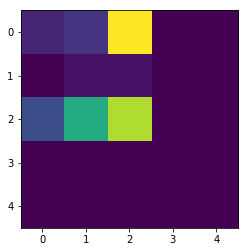

In [226]:
plt.imshow(feature_batch[5,:,:,5])

In [213]:
feature_batch_average = global_average_layer(feature_batch)

In [216]:
feature_batch_average.shape

TensorShape([32, 1280])

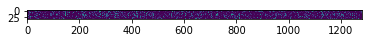

In [231]:
plt.imshow(feature_batch_average)

In [209]:
model = tf.keras.Sequential([
    base_model,
#     2차원으로 만들어준다.
    global_average_layer,
#     기계학습은 2차원
    prediction_layer
])

In [210]:
model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [198]:
model.fit(train_batches, epochs =1 )

    174/Unknown - 8s 8s/step - loss: 1.0872 - accuracy: 0.37 - 11s 5s/step - loss: 0.8635 - accuracy: 0.484 - 14s 5s/step - loss: 0.8176 - accuracy: 0.489 - 17s 4s/step - loss: 0.7796 - accuracy: 0.531 - 19s 4s/step - loss: 0.7862 - accuracy: 0.518 - 22s 4s/step - loss: 0.7730 - accuracy: 0.526 - 24s 3s/step - loss: 0.7567 - accuracy: 0.544 - 27s 3s/step - loss: 0.7392 - accuracy: 0.562 - 30s 3s/step - loss: 0.7135 - accuracy: 0.586 - 32s 3s/step - loss: 0.7100 - accuracy: 0.578 - 35s 3s/step - loss: 0.6969 - accuracy: 0.596 - 37s 3s/step - loss: 0.6940 - accuracy: 0.593 - 40s 3s/step - loss: 0.6772 - accuracy: 0.610 - 43s 3s/step - loss: 0.6679 - accuracy: 0.625 - 46s 3s/step - loss: 0.6537 - accuracy: 0.639 - 48s 3s/step - loss: 0.6369 - accuracy: 0.654 - 51s 3s/step - loss: 0.6324 - accuracy: 0.658 - 54s 3s/step - loss: 0.6257 - accuracy: 0.664 - 57s 3s/step - loss: 0.6170 - accuracy: 0.671 - 60s 3s/step - loss: 0.6068 - accuracy: 0.681 - 62s 3s/step - loss: 0.5958 - accuracy: 0.690

    181/Unknown - 477s 3s/step - loss: 0.2660 - accuracy: 0.89 - 480s 3s/step - loss: 0.2651 - accuracy: 0.89 - 483s 3s/step - loss: 0.2646 - accuracy: 0.89 - 486s 3s/step - loss: 0.2637 - accuracy: 0.89 - 489s 3s/step - loss: 0.2629 - accuracy: 0.89 - 492s 3s/step - loss: 0.2625 - accuracy: 0.89 - 495s 3s/step - loss: 0.2625 - accuracy: 0.89 - 495s 3s/step - loss: 0.2625 - accuracy: 0.8924

KeyboardInterrupt: 

In [165]:
temp = [] 
for layer in base_model.layers[:4]:
    layer.trainable = False 
    temp.append(layer)

In [178]:
model = tf.keras.Sequential(temp)

In [174]:
model.add(flatten)

In [176]:
model.add(prediction_dense)

In [177]:
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_pad (ZeroPadding2D)    (None, 161, 161, 3)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
bn_Conv1 (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
flatten_14 (Flatten)         (None, 204800)            0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 204801    
Total params: 205,793
Trainable params: 204,801
Non-trainable params: 992
_________________________________________________________________


In [180]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [182]:
model.fit(train_batches, epochs = 2)

Epoch 1/2
      1/Unknown - 3s 3s/st - 3s 3s/step

InvalidArgumentError:  Incompatible shapes: [32,1] vs. [32,80,80,32]
	 [[node metrics/accuracy/Equal (defined at D:\01_Program\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_distributed_function_146797]

Function call stack:
distributed_function


In [5]:
2 + 4 + 6

12